<a href="https://colab.research.google.com/github/masayasato0407/temp1/blob/main/DeepSurv_lungCa20210831.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#インストール
!pip install pysurvival

     |████████████████████████████████| 4.7 MB 2.6 MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp37-cp37m-linux_x86_64.whl size=3773243 sha256=7454033d02ec04a0b897d75823ab28fb252d7f1cf1ba82d0f223e2a392b6ba67
  Stored in directory: /root/.cache/pip/wheels/1a/63/e2/32273d765a4e2f4ccac69c8adf97425ca80bab5d0c8447f120
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=b9a3c27d04898cad66f8bbbe62a24dcde42570312f2eae70ae8e294518182a65
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built pysurvival progressbar


In [ ]:
# ライブラリのインポート
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# ローカルファイルを直接アップロードする
from google.colab import files
uploaded = files.upload()

Saving lungCa_train.csv to lungCa_train.csv


In [ ]:
# train dataの読み込み
data_train=pd.read_csv ("lungCa_train.csv",encoding="utf-8")
data_train.head

<bound method NDFrame.head of       age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  wt.loss  time  event
0      74    1        1        90         90       513       10   337      0
1      67    2        0        80         90       131       20   641      1
2      72    1        1        90         70       635       10   181      0
3      72    1        1        80         70       488       38   567      1
4      56    1        2        80         90       713       13   181      0
...   ...  ...      ...       ...        ...       ...      ...   ...    ...
8995   48    2        2       100         80       131       24   707      0
8996   63    1        1        80         90      1225       10   191      1
8997   63    2        3        90         50       975       15   259      1
8998   76    1        0        80         80       975       11   229      1
8999   49    1        0        70         60       875       14   404      0

[9000 rows x 9 columns]>

In [ ]:
# ローカルファイルを直接アップロードする
from google.colab import files
uploaded = files.upload()

Saving lungCa_test.csv to lungCa_test.csv


In [ ]:
#test dataの読み込み
data_test=pd.read_csv ("lungCa_test.csv",encoding="utf-8")
data_test.head

<bound method NDFrame.head of      age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  wt.loss  time  event
0     73    1        1        80         90      1025       20    31      1
1     66    2        0       100         60      1075       13   176      0
2     75    2        1        90         80       413       11   413      1
3     65    2        0        80         90      1075        1   413      0
4     58    1        1        90         80       438       20   643      1
..   ...  ...      ...       ...        ...       ...      ...   ...    ...
995   74    1        1        90         90      1025       34   239      1
996   58    1        1       100         80      1225        7    15      1
997   44    1        1        80         70      1225       37   291      0
998   58    2        1        70         80      2350      -24   163      0
999   69    1        0        60         70       384        0   286      1

[1000 rows x 9 columns]>

In [ ]:
# time,eventの行を定義
time_column = 'time'
event_column = 'event'

In [ ]:
# Defining the modeling features
features = np.setdiff1d(data_train.columns, ['time', 'event']).tolist()

In [ ]:
# X, T, E inputの作成
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['time'].values, data_test['time'].values
E_train, E_test = data_train['event'].values, data_test['event'].values

In [ ]:
#ネットワークのユニット数と活性化関数の定義
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]

In [ ]:
# モデルの作成
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(X_train, T_train, E_train, lr=1e-3, init_method='xav_uniform')

NonLinearCoxPHModel( Layer(1): activation = BentIdentity, num_units = 150 )

In [ ]:
#test sampleでのc-index計算
c_index = concordance_index(nonlinear_coxph, X_test, T_test, E_test) 
print('C-index: {:.2f}'.format(c_index))

C-index: 0.51


In [ ]:
#train sampleでのc-index計算
c_index = concordance_index(nonlinear_coxph, X_train, T_train, E_train) 
print('C-index: {:.2f}'.format(c_index))

C-index: 0.52


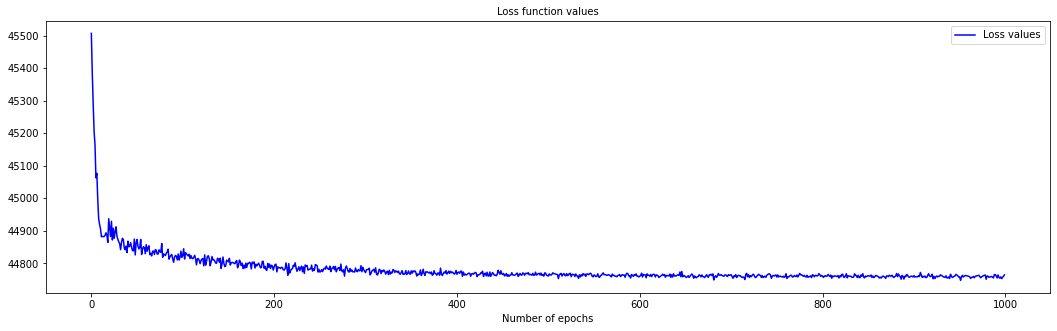

In [ ]:
#epochによるlossの表示
from pysurvival.utils.display import display_loss_values
display_loss_values(nonlinear_coxph)

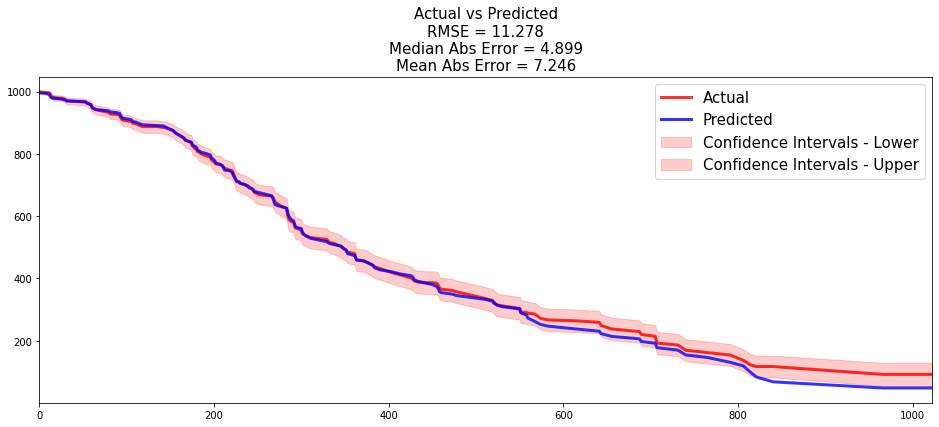

In [ ]:
#test dataのカプランマイヤーの予測
results = compare_to_actual(nonlinear_coxph, X_test, T_test, E_test,
                            is_at_risk = True,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])